In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

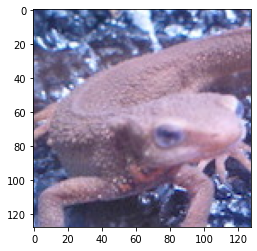

In [32]:
img = cv2.imread("../imori.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [36]:
class CannyEdgeDetector:
    def BGR2GRAY(self, img):
        b = img[:, :, 0].copy()
        g = img[:, :, 1].copy()
        r = img[:, :, 2].copy()
        output_image = (0.2126*r + 0.7152*g + 0.0722*b).astype("uint8")
        return output_image
    
    def gaussian_filter(self, img, ksize=5, sigma=1.4):
        K = np.zeros((ksize, ksize))
        for i in range(ksize):
            for j in range(ksize):
                x = i - (ksize - 1) // 2
                y = j - (ksize - 1) // 2
                a = -(x*x+y*y)/(2*(sigma**2))
                K[i, j] = 1/(2*np.pi*(sigma**2)) * np.exp(a)
        K /= np.sum(K)

        pad = ksize // 2
        H, W = img.shape
        input_image = np.zeros((H+2*pad, W+2*pad))
        output_image = input_image.copy()
        input_image[pad:H+pad, pad:W+pad] = img.copy().astype(np.float)
        for i in range(H):
            for j in range(W):
                output_image[pad+i, pad+j] = np.sum(K * input_image[i:i+ksize, j:j+ksize])
                output_image[pad+i, pad+j] = np.clip(output_image[pad+i, pad+j], 0, 255).astype("uint8")
        output_image = output_image[pad:pad+H, pad:pad+W]
        return output_image
    
    def sobel_filter_v(self, img):
        ksize = 3
        pad = ksize // 2
        K = [ [1, 2, 1], [0, 0, 0], [-1, -2, -1] ]

        H, W = img.shape
        input_image = np.zeros((H+2*pad, W+2*pad))
        input_image[pad:pad+H, pad:pad+W] = img.copy()
        output_image = input_image.copy()
        for i in range(H):
            for j in range(W):
                output_image[pad+i, pad+j] = np.sum(K * input_image[i:i+ksize, j:j+ksize])
        output_image = np.clip(output_image[pad:pad+H, pad:pad+W], 0, 255).astype("uint8")
        return output_image
    
    def sobel_filter_h(self, img):
        ksize = 3
        pad = ksize // 2
        K = [ [1, 0, -1], [2, 0, -2], [1, 0, -1] ]

        H, W = img.shape
        input_image = np.zeros((H+2*pad, W+2*pad))
        input_image[pad:pad+H, pad:pad+W] = img.copy()
        output_image = input_image.copy()
        for i in range(H):
            for j in range(W):
                output_image[pad+i, pad+j] = np.sum(K * input_image[i:i+ksize, j:j+ksize])
        output_image = np.clip(output_image[pad:pad+H, pad:pad+W], 0, 255).astype("uint8")
        return output_image
    
    def quantize_angle(self, a):
        angle = a.copy()
        angle *= 180 / np.pi
        while angle < -22.5: angle += 180
        while angle >= 157.5: angle -= 180
        
        quantized_angle = 0
        if 22.5 < angle <= 67.5:
            quantized_angle = 45
        elif 67.5 < angle <= 112.5:
            quantized_angle = 90
        elif 112.5 < angle <= 157.5:
            quantized_angle = 135
        return quantized_angle
    
    def non_maximum_suppression(self, angle, edge_):
        H, W = angle.shape
        edge = edge_.copy()
        edge_pad = np.zeros((H+2, W+2))
        edge_pad[1:1+H, 1:1+W] = edge_.copy()
        
        for i in range(1, H+1):
            for j in range(1, W+1):
                if angle[i-1, j-1] == 0:
                    if np.amax([edge_pad[i, j], edge_pad[i, j-1], edge_pad[i, j+1]]) != edge_pad[i, j]:
                        edge[i-1, j-1] = 0
                    
                if angle[i-1, j-1] == 45:
                    if np.amax([edge_pad[i, j], edge_pad[i-1, j+1], edge_pad[i+1, j-1]]) != edge_pad[i, j]:
                        edge[i-1, j-1] = 0
                    
                if angle[i-1, j-1] == 90:
                    if np.amax([edge_pad[i, j], edge_pad[i-1, j], edge_pad[i+1, j]]) != edge_pad[i, j]:
                        edge[i-1, j-1] = 0
                    
                if angle[i-1, j-1] == 135:
                    if np.amax([edge_pad[i, j], edge_pad[i-1, j-1], edge_pad[i+1, j+1]]) != edge_pad[i, j]:
                        edge[i-1, j-1] = 0
        edge = np.clip(edge, 0, 255)
        return edge
    
    def apply_threshold(self, img, HT=50, LT=20):
        print(HT, LT)
        H, W = img.shape
        input_img = np.zeros((H+2, W+2))
        input_img[1:1+H, 1:1+W] = img.copy()
        input_img[input_img >= HT] = 255
        input_img[input_img <= LT] = 0
        
        for i in range(1, H+1):
            for j in range(1, W+1):
                if LT < input_img[i, j] < HT and len(np.where(input_img[i-1:i+2, j-1:j+2] > HT)[0]) > 0:
                    input_img[i, j] = 255
        output_img = input_img[1:1+H, 1:1+W]
        return output_img
    
    def detect_edge(self, img):
        img_gray = self.BGR2GRAY(img)
        img_gaussian = self.gaussian_filter(img_gray, ksize=5, sigma=1.4)
        img_sobel_v = self.sobel_filter_v(img_gaussian)
        img_sobel_h = self.sobel_filter_h(img_gaussian)

        H, W = img_gray.shape
        edge = np.sqrt(np.power(img_sobel_h.astype(np.float32), 2) + np.power(img_sobel_v.astype(np.float32), 2))
        edge = np.clip(edge, 0, 255)
        img_sobel_h = np.maximum(img_sobel_h, 1e-10)
        angle = np.arctan2(img_sobel_v, img_sobel_h)
        for i in range(H):
            for j in range(W):
                angle[i, j] = self.quantize_angle(angle[i, j])
                
        edge_nms = self.non_maximum_suppression(angle, edge)
        edge_out = self.apply_threshold(edge_nms, HT=50, LT=20)
        
        plt.figure(figsize=(15, 15))
        plt.subplot(2, 2, 1)
        plt.imshow(edge.astype("uint8"), cmap="gray", vmin=0, vmax=255)
        plt.title("Edge Strength")
        plt.subplot(2, 2, 2)
        plt.imshow(angle.astype("uint8"), cmap="gray", vmin=0, vmax=255)
        plt.title("Edge Angle")
        plt.subplot(2, 2, 3)
        plt.imshow(edge_nms.astype("uint8"), cmap="gray", vmin=0, vmax=255)
        plt.title("Non-maximum Suppression")
        plt.subplot(2, 2, 4)
        plt.imshow(edge_out.astype("uint8"), cmap="gray", vmin=0, vmax=255)
        plt.title("Canny")
        plt.show()
        
        return edge_out

In [19]:
def bgr_to_gray(img):
    b = img[:, :, 0].copy()
    g = img[:, :, 1].copy()
    r = img[:, :, 2].copy()
    output_image = (0.2126*r + 0.7152*g + 0.0722*b).astype("uint8")
    return output_image

In [20]:
def otsu_binarization(img_gray):
    # Otsu's binarization algorithm
    max_variance, threshold = -1, -1
    for v in range(0, 256):
        c0 = np.count_nonzero(img_gray < v)
        c1 = img_gray.shape[0] * img_gray.shape[1] - c0
        v0 = img_gray[np.where(img_gray < v)]
        v1 = img_gray[np.where(img_gray >= v)]
        m0 = np.mean(v0) if len(v0) > 0 else 0
        m1 = np.mean(v1) if len(v1) > 0 else 0
        variance = c0 * c1 * ((m0-m1)**2)
        if variance > max_variance:
            max_variance = variance
            threshold = v

    print("image shape =", img_gray.shape)
    print("optimal threshold =", threshold)
    img_binary = np.vectorize(lambda x: 0 if x < threshold else 255)(img_gray)
    return img_binary

image shape = (128, 128)
optimal threshold = 127


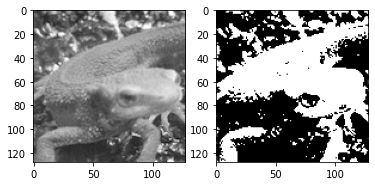

In [21]:
img_gray = bgr_to_gray(img)
img_gray_otsu = otsu_binarization(img_gray)
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray", vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.imshow(img_gray_otsu, cmap="gray", vmin=0, vmax=255)
plt.show()

In [26]:
# 膨張
def morphology_erode(img, iteration=1):
    H, W = img.shape
    input_img = np.zeros((H+2, W+2))
    input_img[1:1+H, 1:1+W] = img.copy()
    
    K = [ [0, 1, 0], [1, 1, 1], [0, 1, 0] ]
    for t in range(iteration):
        output_img = np.zeros((H+2, W+2))
        for i in range(1, H+1):
            for j in range(1, W+1):
                if np.sum(K * input_img[i-1:i+2, j-1:j+2]) >= 255:
                    output_img[i, j] = 255
        input_img = output_img.copy()
    output_img = output_img[1:1+H, 1:1+W]
    return output_img

In [27]:
# 収縮
def morphology_dilate(img, iteration=1):
    H, W = img.shape
    input_img = np.zeros((H+2, W+2))
    input_img[1:1+H, 1:1+W] = img.copy()
    
    K = [ [0, 1, 0], [1, 1, 1], [0, 1, 0] ]
    for t in range(iteration):
        output_img = np.ones((H+2, W+2)) * 255
        for i in range(1, H+1):
            for j in range(1, W+1):
                if np.sum(K * input_img[i-1:i+2, j-1:j+2]) < 255*5:
                    output_img[i, j] = 0
        input_img = output_img.copy()
    output_img = output_img[1:1+H, 1:1+W]
    return output_img

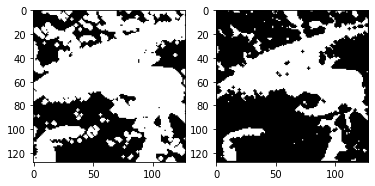

In [28]:
img_erode = morphology_erode(img_gray_otsu)
img_dilate = morphology_dilate(img_gray_otsu)
plt.subplot(1, 2, 1)
plt.imshow(img_erode, cmap="gray", vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.imshow(img_dilate, cmap="gray", vmin=0, vmax=255)
plt.show()

In [39]:
def morphology_opening(img, iteration=1):
    img_out = morphology_dilate(img, iteration)
    img_out = morphology_erode(img_out, iteration)
    return img_out

In [40]:
def morphology_closing(img, iteration=1):
    img_out = morphology_erode(img, iteration)
    img_out = morphology_dilate(img_out, iteration)
    return img_out

50 20


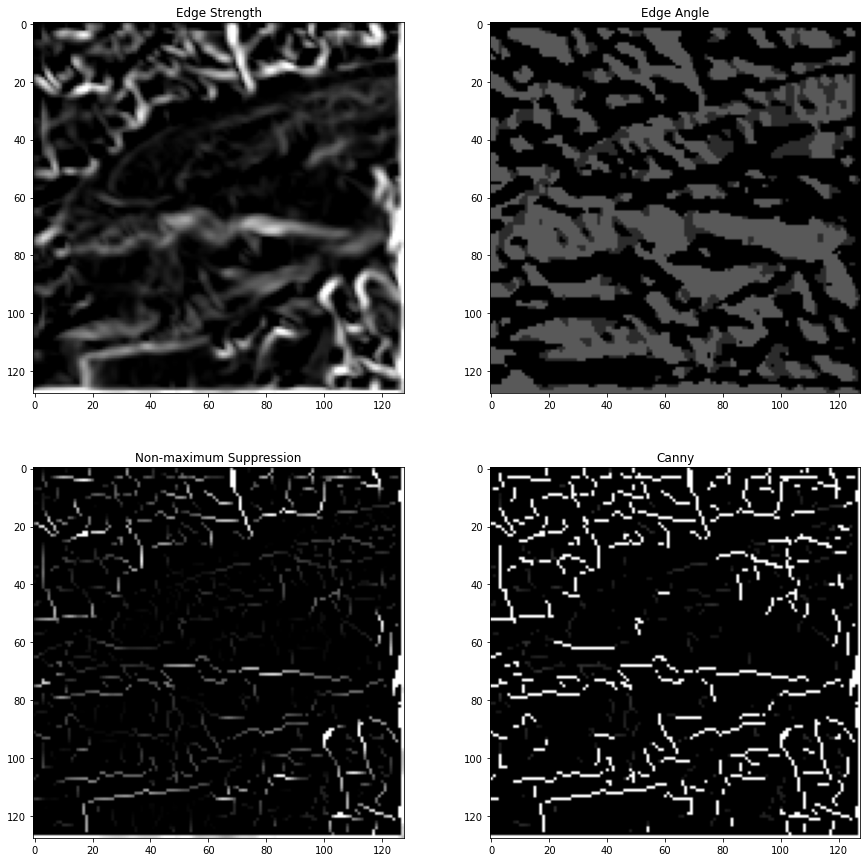

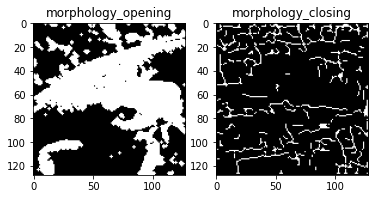

In [41]:
canny = CannyEdgeDetector()
img_canny = canny.detect_edge(img)

img_opening = morphology_opening(img_gray_otsu, iteration=1)
img_closing = morphology_closing(img_canny, iteration=1)
plt.subplot(1, 2, 1)
plt.imshow(img_opening, cmap="gray", vmin=0, vmax=255)
plt.title("morphology_opening")
plt.subplot(1, 2, 2)
plt.imshow(img_closing, cmap="gray", vmin=0, vmax=255)
plt.title("morphology_closing")
plt.show()